# Enunciado
## Cálculo de la duración de un proyecto usando el Método de Montecarlo

>Considere el proyecto cuya información se adjunta.
> 1. Dibuje el grafo PERT del proyecto.
> 2. Determine las ecuaciones de los tiempos tempranos de cada nodo.
> 3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.
> 4. Determina la duración media y la desviación típica de la duración del proyecto.
> 5. Determine la duración para una probabilidad de completar antes el proyecto del 98%.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
pmule_path = r'/content/gdrive/MyDrive/COMPARTIDOS/COMPARTIDO_AREA/DOCENCIA/Direccion_de_Proyectos/pmule/compartido_publico_alumnos/'

import sys
sys.path.insert(1, pmule_path + "src")
!source {pmule_path}venv/bin/activate
!apt install libgraphviz-dev
!python -m pip install pygraphviz

Mounted at /content/gdrive/
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 k

In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline

datos_enunciado = pd.DataFrame([
#  actividad, predecesora, duracion media, desviación típica
     ('A',    '---  ', 10, 1.5 ),
     ('B',    '---  ',  5, 0.4 ),
     ('C',    'A    ',  6, 0.8 ),
     ('D',    'A    ',  2, 0.7 ),
     ('E',    'B,C,D',  7, 1.8 ),
     ('F',    'B,D  ',  8, 0.8 ),
     ('G',    'E,F  ',  4, 1.4 ),
     ('H',    'B    ',  7, 1.6 ),
] ,columns=['activity', 'predecessor', 'mean', 'stdev']).set_index('activity')

datos_enunciado

,predecessor,mean,stdev
activity,,,
A,---,10,1.5
B,---,5,0.4
C,A,6,0.8
D,A,2,0.7
E,"B,C,D",7,1.8
F,"B,D",8,0.8
G,"E,F",4,1.4
H,B,7,1.6


## Solución
### Apartado 1
> 1. Dibuje el grafo PERT del proyecto.

In [3]:
from pmule import PredecessorTable, ProjectGraph
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

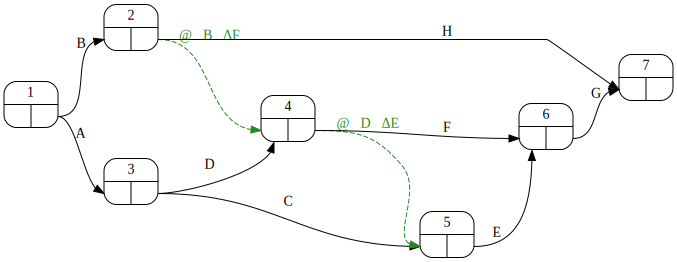

In [4]:
datos_proyecto =  datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
proyecto = prelaciones.create_project()
proyecto.pert()

### Apartado 2
> 2. Determine las ecuaciones de los tiempos tempranos de cada nodo.


$t_1 = 0$

$t_2 = t_1 + B$

$t_3 = t_1 + A$

$ t_4 = \max \begin{Bmatrix} t_2 + d_{@∇B⤑ΔF} \\ t_3 + D \end{Bmatrix} $

$ t_5 = \max \begin{Bmatrix} t_3 + C \\ t_4 + d_{@∇D⤑ΔE} \end{Bmatrix} $

$ t_6 = \max \begin{Bmatrix} t_5 + E \\ t_4 + F \end{Bmatrix} $

$ t_7 = \max \begin{Bmatrix} t_6+ G \\ t_2 + H \end{Bmatrix} $


### Apartado 3
> 3. Calcule, utilizando las ecuaciones, los tiempos tempranos de cada nodo para 1000 iteraciones del método de MonteCarlo.

#### Generación aleatoria de las duraciones de las actividades

In [5]:
number_of_samples = 1000

In [6]:
activity_names = datos_proyecto.index
duration = pd.DataFrame([np.random.normal(size = number_of_samples,
                                          loc  = datos_proyecto.loc[task, 'mean',],
                                          scale= datos_proyecto.loc[task, 'stdev'])
                         for task in activity_names
                        ],
                        index=activity_names).T

In [7]:
duration.head()

activity,A,B,C,D,E,F,G,H
0,11.609386,4.898308,6.609900,2.506308,6.674375,7.800552,5.413120,5.072707
1,8.277425,5.370720,7.100475,1.515262,6.853291,8.020620,6.347743,6.403224
2,12.653370,4.613418,7.025983,1.548537,5.659933,8.109780,3.246762,5.152968
3,10.264444,4.465176,6.291622,1.317909,9.522908,9.593525,6.404882,6.217450
4,10.957571,5.456697,5.305655,1.141765,5.141694,7.446113,4.039807,8.034260


#### Cálculo de los tiempos tempranos

In [8]:
def row_max(A,B):
    return pd.concat([A,B], axis=1).max(axis=1)

In [9]:
t_early = duration.copy()
t_early.eval("""t_1 = 0
                t_2 = t_1 + B

                t_3 = t_1 + A

                input_D = t_3 + D
                input_f_B_F = t_2 + 0
                t_4 = @row_max(input_D, input_f_B_F)

                input_C = t_3 + C
                input_f_D_E = t_4 + 0
                t_5 = @row_max(input_C, input_f_D_E)

                input_E = t_5 + E
                input_F = t_4 + F
                t_6 = @row_max(input_E, input_F)

                input_G = t_6 + G
                input_H = t_2 + H
                t_7 = @row_max(input_G, input_H)
                """, inplace=True)

In [10]:
tiempos_nodos = ['t_'+ str(num) for num in range(1, 8)]
t_early.loc[0:10, : ]

activity,A,B,C,D,E,F,G,H,t_1,t_2,t_3,input_D,input_f_B_F,t_4,input_C,input_f_D_E,t_5,input_E,input_F,t_6,input_G,input_H,t_7
0,11.609386,4.898308,6.609900,2.506308,6.674375,7.800552,5.413120,5.072707,0,4.898308,11.609386,14.115694,4.898308,14.115694,18.219286,14.115694,18.219286,24.893661,21.916246,24.893661,30.306781,9.971015,30.306781
1,8.277425,5.370720,7.100475,1.515262,6.853291,8.020620,6.347743,6.403224,0,5.370720,8.277425,9.792687,5.370720,9.792687,15.377900,9.792687,15.377900,22.231190,17.813307,22.231190,28.578934,11.773944,28.578934
2,12.653370,4.613418,7.025983,1.548537,5.659933,8.109780,3.246762,5.152968,0,4.613418,12.653370,14.201908,4.613418,14.201908,19.679354,14.201908,19.679354,25.339286,22.311688,25.339286,28.586048,9.766386,28.586048
3,10.264444,4.465176,6.291622,1.317909,9.522908,9.593525,6.404882,6.217450,0,4.465176,10.264444,11.582353,4.465176,11.582353,16.556066,11.582353,16.556066,26.078974,21.175878,26.078974,32.483857,10.682626,32.483857
4,10.957571,5.456697,5.305655,1.141765,5.141694,7.446113,4.039807,8.034260,0,5.456697,10.957571,12.099336,5.456697,12.099336,16.263226,12.099336,16.263226,21.404920,19.545449,21.404920,25.444727,13.490957,25.444727
5,8.448775,4.649766,6.329059,2.547803,6.399966,7.368226,3.399288,6.303825,0,4.649766,8.448775,10.996578,4.649766,10.996578,14.777834,10.996578,14.777834,21.177800,18.364804,21.177800,24.577088,10.953592,24.577088
6,10.682326,4.945050,6.416199,0.616358,9.901905,8.514976,0.919174,5.091070,0,4.945050,10.682326,11.298684,4.945050,11.298684,17.098525,11.298684,17.098525,27.000430,19.813659,27.000430,27.919604,10.036119,27.919604
7,12.154677,5.147551,5.538235,2.591371,9.104845,7.955049,4.694372,5.944992,0,5.147551,12.154677,14.746048,5.147551,14.746048,17.692913,14.746048,17.692913,26.797758,22.701097,26.797758,31.492131,11.092543,31.492131
8,7.486375,4.973251,4.949537,1.253761,7.917213,7.620319,6.379016,10.153364,0,4.973251,7.486375,8.740135,4.973251,8.740135,12.435912,8.740135,12.435912,20.353125,16.360454,20.353125,26.732141,15.126615,26.732141
9,11.519087,4.512040,6.319479,2.534223,6.397274,8.213478,4.626570,9.095868,0,4.512040,11.519087,14.053311,4.512040,14.053311,17.838566,14.053311,17.838566,24.235840,22.266789,24.235840,28.862410,13.607908,28.862410


### Apartado 4
> 4. Determina la duración media y la desviación típica de la duración del proyecto.

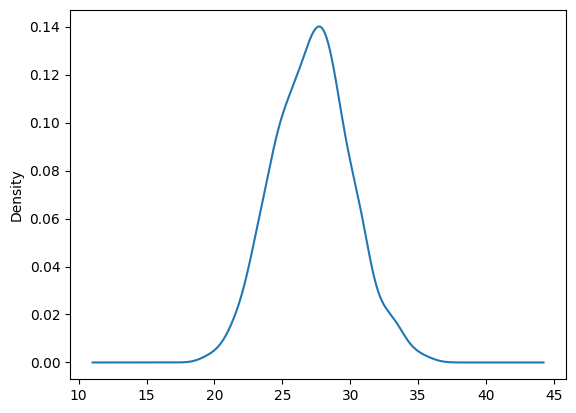

In [11]:
t_early['t_7'].plot(kind='density');

In [12]:
t_early['t_7'].describe()

,t_7
count,1000.000000
mean,27.211195
std,2.806710
min,19.324539
25%,25.220977
50%,27.206860
75%,29.051027
max,35.928363


In [13]:
f"La duración media del proyecto es:{t_early['t_7'].mean()}, la desviación típica de la duración del proyecto es:{t_early['t_7'].std()}"

'La duración media del proyecto es:27.211195332521832, la desviación típica de la duración del proyecto es:2.806709827669596'

La desviación típica de la duración del proyecto es:

### Apartado 5
> 5. Determine la duración para una probabilidad de completar antes el proyecto del 98%.

Podemos ordenar los valores en sentido ascendente y quedarnos con aquél valor superior al 98% de las muestras.

In [14]:
t_early['t_7'].sort_values(ascending=True).iloc[int(0.98*number_of_samples)]

33.28645242521138

O bien, utilizando la función `quantile`

In [15]:
t_early['t_7'].quantile(q=0.98, interpolation='higher')

33.28645242521138